# Этичность банков

In [262]:
import pandas as pd
import numpy as np

In [263]:
del_datasphere_variables('train')
del_datasphere_variables('train_new')
del_datasphere_variables('bag')

In [276]:
del_datasphere_variables('bag_of_words')

In [486]:
del_datasphere_variables('cat')
del_datasphere_variables('cat_2')
del_datasphere_variables('train_2')

## Считаем данные

In [516]:
train = pd.read_csv("/home/jupyter/mnt/s3/bac2/train.csv")
print(train.shape)
train.head()

(19361, 5)


,Unnamed: 0,sentence,1category,2category,sentiment
0,4754,При этом всегда получал качественные услуги.,Communication,NaN,+
1,4417,"Не вижу, за что хотя бы 2 поставить, сервис на 1!",?,NaN,−
2,3629,"Вот так ""Мой любимый"" банк МКБ меня обманул.",?,NaN,−
3,11640,Отвратительное отношение к клиентам.,Communication,NaN,−
4,5571,"Всегда в любое время дня и ночи помогут, ответ...",Communication,NaN,+


Посмотрим на категории

In [495]:
train.groupby("1category").count()

,sentence,2category,sentiment
1category,,,
?,5926,0,5926
Communication,7193,350,7193
Price,366,83,366
Quality,5630,534,5630
Safety,246,32,246


Посмотрим на сентименты

In [496]:
train.groupby("sentiment").count()

,sentence,1category,2category
sentiment,,,
+,6262,6262,419
?,2907,2907,18
−,10192,10192,562


## Препроцессинг и чистка текста

In [517]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from pymorphy2 import MorphAnalyzer

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [590]:
stop_words = stopwords.words('russian')
pymorphy = MorphAnalyzer()


def remove_stopwords(words: list):
    words = [w.lower() for w in words]
    return [s for s in list(set(words) - set(stop_words))]


def lemma(words):
    return [pymorphy.parse(s)[0].normal_form for s in words]


def preproccesing_text(dataframe: pd.DataFrame, col: str) -> pd.DataFrame:
    tokenizer = RegexpTokenizer(r'\w+')
    dataframe["tokens"] = dataframe[col].apply(tokenizer.tokenize)
    dataframe["norm"] = dataframe["tokens"].apply(remove_stopwords)
    dataframe["lemma"] = dataframe.norm.apply(lemma)
    dataframe["lemma_str"] = dataframe["lemma"].apply(lambda x: " ".join(x))
    return dataframe

In [591]:
train = preproccesing_text(train, col="sentence")
train.head()

,Unnamed: 0,sentence,1category,2category,sentiment,tokens,norm,lemma,lemma_str
0,4754,При этом всегда получал качественные услуги.,Communication,NaN,+,"[При, этом, всегда, получал, качественные, усл...","[услуги, качественные, получал]","[услуга, качественный, получать]",услуга качественный получать
1,4417,"Не вижу, за что хотя бы 2 поставить, сервис на 1!",?,NaN,−,"[Не, вижу, за, что, хотя, бы, 2, поставить, се...","[1, вижу, 2, сервис, хотя, поставить]","[1, видеть, 2, сервис, хотя, поставить]",1 видеть 2 сервис хотя поставить
2,3629,"Вот так ""Мой любимый"" банк МКБ меня обманул.",?,NaN,−,"[Вот, так, Мой, любимый, банк, МКБ, меня, обма...","[любимый, банк, обманул, мкб]","[любимый, банк, обмануть, мкб]",любимый банк обмануть мкб
3,11640,Отвратительное отношение к клиентам.,Communication,NaN,−,"[Отвратительное, отношение, к, клиентам]","[отвратительное, отношение, клиентам]","[отвратительный, отношение, клиент]",отвратительный отношение клиент
4,5571,"Всегда в любое время дня и ночи помогут, ответ...",Communication,NaN,+,"[Всегда, в, любое, время, дня, и, ночи, помогу...","[дня, ночи, любое, ответят, время, помогут, ре...","[день, ночь, любой, ответить, время, помочь, р...",день ночь любой ответить время помочь решить


In [520]:
all_words = set()
for lemma in train['lemma']:
    all_words.update(lemma)

In [503]:
bag = pd.DataFrame(columns=list(all_words), index=train['sentence'], data=np.zeros((train.shape[0], len(all_words))))
bag.head(1)

Failed to deserialize variable 'bag'. Run the following code to delete it:
  del_datasphere_variables('bag')
Traceback (most recent call last):
  File "/kernel/lib/python3.8/site-packages/ml_kernel/state/state_protocol.py", line 283, in _load_component
    value = unpickler.load()
  File "/kernel/lib/python3.8/site-packages/ipystate/impl/dispatch/dataframe.py", line 67, in _create_df
    df = pd.read_parquet(br, engine='pyarrow')
  File "/home/jupyter/.local/lib/python3.8/site-packages/pandas/io/parquet.py", line 493, in read_parquet
    impl = get_engine(engine)
  File "/home/jupyter/.local/lib/python3.8/site-packages/pandas/io/parquet.py", line 71, in get_engine
    return PyArrowImpl()
  File "/home/jupyter/.local/lib/python3.8/site-packages/pandas/io/parquet.py", line 133, in __init__
    import_optional_dependency(
  File "/home/jupyter/.local/lib/python3.8/site-packages/pandas/compat/_optional.py", line 171, in import_optional_dependency
    raise ImportError(msg)
ImportError: Pa

,хитрость,талон,аэропорт,0726,выработать,тинькова,7,попасть,youtube,ч,модель,импортировать,ios,дополнительно,верх,попугай,нерасторопный,процветание,разгильдяй,9008,критично,выводить,ахх,модный,ждать,прописывать,оптимизировать,внятный,шаг,бкс,намекать,бормотать,испариться,троицкий,74а,убыток,попытка,01744,малоохтинский,айтишник,...,жулик,придача,наличные,шустро,будт,собираться,обвинять,988,восновный,разница,февраль,22,обязать,катастрофически,порядочно,жку,936418,рвать,красноярск,предварительный,борзеть,прошдый,мусорк,2008,nbsp,город,скидывать,около,изготовление,отсутствовать,связать,key,сухов,стойкий,сек09,дезинформация,доброжелательно,6978,вплоть,одинцово
sentence,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
При этом всегда получал качественные услуги.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Разделение выборки

In [521]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

In [281]:
le = LabelEncoder()


def split_data(type_pred: str, dataframe: pd.DataFrame):
    list_corpus = dataframe["lemma_str"].tolist()
    list_labels = dataframe[type_pred].tolist()
    le.fit(list_labels)
    list_labels = le.transform(list_labels)

    X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.1, random_state=42, stratify=list_labels)
    return X_train, X_test, y_train, y_test

## Мешок слов

In [522]:
def bag_of_words(data):
    count_vectorizer = CountVectorizer()
    emb = count_vectorizer.fit_transform(data)
    return emb, count_vectorizer

## Обучение при помощи логистической регрессии

In [523]:
from sklearn.linear_model import LogisticRegression

## Подсчет метрик

In [524]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

In [525]:
def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1


## График для просмотра разделения классов

In [526]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [527]:
def sen_plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
    lsa = TruncatedSVD(n_components=3)
    lsa.fit(test_data)
    lsa_scores = lsa.transform(test_data)
    colors = ['green', 'blue','red']
    color_column = [colors[label] for label in test_labels]
    if plot:
        plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=color_column)
        red_patch = mpatches.Patch(color='red', label='Negative')
        blue_patch = mpatches.Patch(color='blue', label='Neuteral')
        green_patch = mpatches.Patch(color='green', label='Positive')
        plt.legend(handles=[red_patch, blue_patch, green_patch], prop={'size': 30})


def cat_plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
    lsa = TruncatedSVD(n_components=5)
    lsa.fit(test_data)
    lsa_scores = lsa.transform(test_data)
    colors = ['green', 'blue', 'red', 'orange', 'purple']
    color_column = [colors[label] for label in test_labels]
    if plot:
        plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=color_column)
        unknown_patch = mpatches.Patch(color='green', label='Unknown')
        communication_patch = mpatches.Patch(color='blue', label='Communication')
        price_patch = mpatches.Patch(color='red', label='Price')
        quality_patch = mpatches.Patch(color='orange', label='Quality')
        safety_patch = mpatches.Patch(color='purple', label='Safety')
        plt.legend(handles=[unknown_patch, communication_patch, price_patch, quality_patch,safety_patch ], prop={'size': 30})

## Матрица ошибок

In [289]:
import itertools
from sklearn.metrics import confusion_matrix

In [290]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Матрица ошибок', cmap=plt.cm.summer):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

## Построение ROC-кривой

In [368]:
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.metrics import RocCurveDisplay
from itertools import cycle
from sklearn.metrics import roc_auc_score

In [566]:
def roc_curve(X_train, y_train, X_test, y_test, encoder):
    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)
    n_samples, n_classes = y_onehot_test.shape
    print(n_classes)
    
    classifier = LogisticRegression()
    y_score = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    

    colors_list = list(colors._colors_full_map.values())
    for class_id, color in zip(range(n_classes), colors_list[:n_classes]):
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_score[:, class_id],
            name=f"ROC curve for {encoder.inverse_transform([class_id])[0]}",
            color=color,
            ax=ax,
        )

    plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
    plt.legend()
    plt.show()


## Сентименты

In [532]:
sen = LabelEncoder()
list_corpus_s = train[["Unnamed: 0", "sentence", "lemma_str"]]
list_labels_s = train["sentiment"].tolist()
sen.fit(list_labels_s)
list_labels_s = sen.transform(list_labels_s)

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(list_corpus_s, list_labels_s, test_size=0.1, random_state=42, stratify=list_labels_s)
X_train_counts_s, count_vectorizer_s = bag_of_words(X_train_s["lemma_str"])
X_test_counts_s = count_vectorizer_s.transform(X_test_s["lemma_str"])

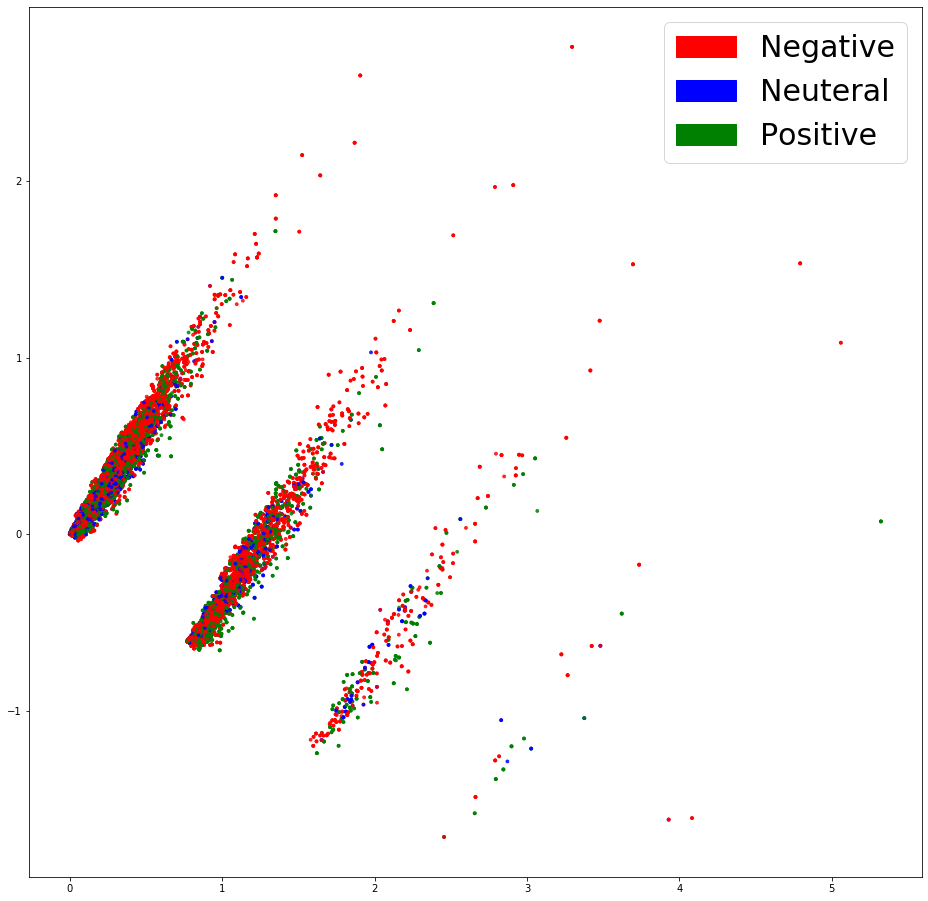

In [451]:
fig = plt.figure(figsize=(16, 16))          
sen_plot_LSA(X_train_counts_s, y_train_s)
plt.show()

Обучение модели для предсказывания сентиментов

In [533]:
sentiment = LogisticRegression(class_weight='balanced', solver='newton-cg', multi_class='multinomial', n_jobs=-1, random_state=42)
sentiment.fit(X_train_counts_s, y_train_s)
y_predicted_s = sentiment.predict(X_test_counts_s)

In [547]:
pred = pd.DataFrame(data=sentiment.predict_proba(X_test_counts_s), columns=sen.inverse_transform([0, 1, 2]))
X_test_s.index = pred.index
sent = X_test_s[["Unnamed: 0", "sentence"]]
ans_s = pd.concat([sent, pred], axis=1)
ans_s.to_csv("/home/jupyter/mnt/s3/bac2/sentiment_prob.csv", encoding="utf-8")

In [548]:
ans_s.head()

,Unnamed: 0,sentence,+,?,−
0,624,"Чувствуется заинтересованность, высокая клиент...",0.980565,0.017465,0.001970
1,17679,"По состоянию на 25.06.2020 деньги не вернули, ...",0.027685,0.117331,0.854984
2,8694,Ответ я получил просто фееричный - у нас нет т...,0.005867,0.066670,0.927463
3,3485,Так что не советую никому пользоваться услугам...,0.001327,0.007165,0.991508
4,1221,"Активно пользовался кредитной картой, которую ...",0.015888,0.973594,0.010518


3


/home/jupyter/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


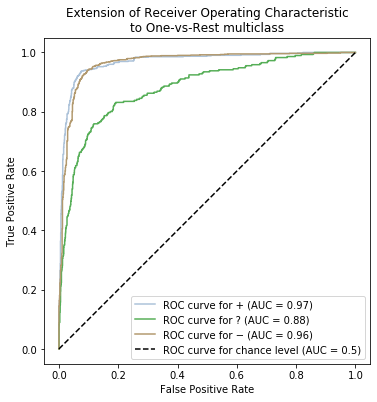

In [537]:
roc_curve(X_train_counts_s, y_train_s, X_test_counts_s, y_test_s, sen)

In [455]:
accuracy, precision, recall, f1 = get_metrics(y_test_s, y_predicted_s)
print("Метрики для сентиментов")
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

Метрики для сентиментов
accuracy = 0.857, precision = 0.870, recall = 0.857, f1 = 0.862


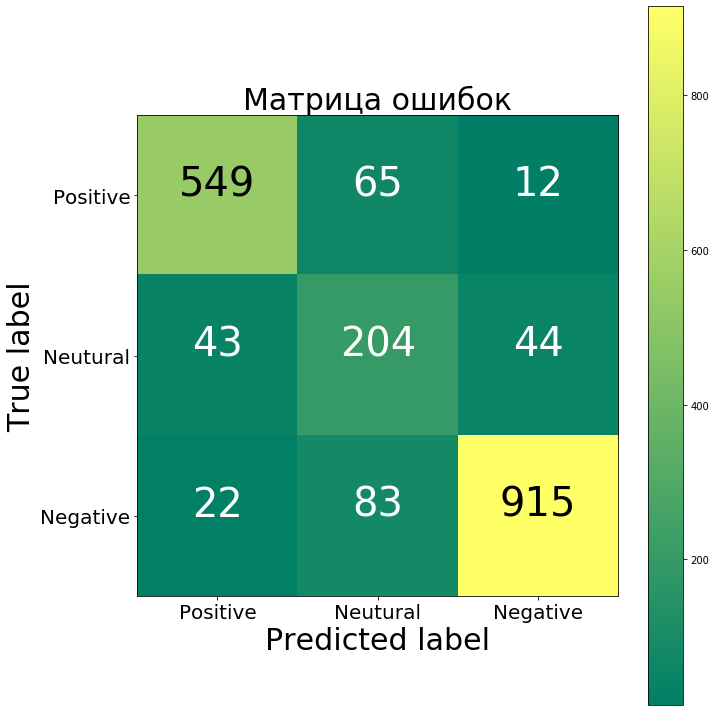

[[549  65  12]
 [ 43 204  44]
 [ 22  83 915]]


In [456]:
cm = confusion_matrix(y_test_s, y_predicted_counts_s)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Positive', 'Neutural', 'Negative'], normalize=False, title='Матрица ошибок')
plt.show()
print(cm)

## Категории

In [584]:
# cat = train[train['2category'].notna()]
# cat_2 = cat.drop('1category', axis=1)
# cat_2.rename(columns={'2category': '1category'}, inplace=True)
# train_2 = train.drop('2category', axis=1)
# train_new = pd.concat([train_2, cat_2])
# train_new.head()

(20360, 8)

In [585]:
catg = LabelEncoder()
list_corpus_c = train[["Unnamed: 0", "sentence", "lemma_str"]]
list_labels_c = train["1category"].tolist()
catg.fit(list_labels_c)
list_labels_c = catg.transform(list_labels_c)

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(list_corpus_c, list_labels_c, test_size=0.1, random_state=42, stratify=list_labels_c)
X_train_counts_c, count_vectorizer_c = bag_of_words(X_train_c["lemma_str"])
X_test_counts_c = count_vectorizer_c.transform(X_test_c["lemma_str"])

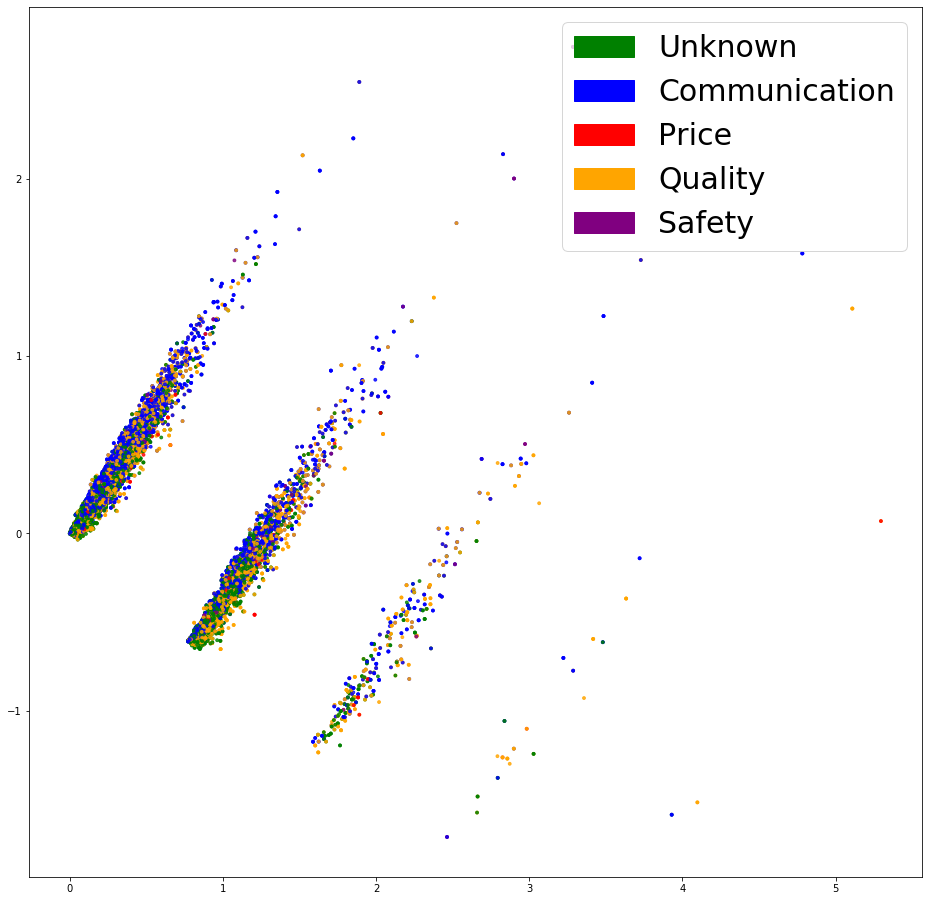

In [467]:
fig = plt.figure(figsize=(16, 16))          
cat_plot_LSA(X_train_counts_c, y_train_c)
plt.show()

In [541]:
category = LogisticRegression(penalty='l2', class_weight='balanced', solver='newton-cg', multi_class='multinomial', n_jobs=-1, random_state=42)
category.fit(X_train_counts_c, y_train_c)
y_predicted_c = category.predict(X_test_counts_c)

In [586]:
pred = pd.DataFrame(data=category.predict_proba(X_test_counts_c), columns=catg.inverse_transform([0, 1, 2, 3, 4]))
X_test_c.index = pred.index
sent = X_test_c[["Unnamed: 0", "sentence"]]
ans_c = pd.concat([sent, pred], axis=1)
ans_c.to_csv("/home/jupyter/mnt/s3/bac2/category_prob.csv", encoding="utf-8")

In [587]:
ans_c.head()

,Unnamed: 0,sentence,?,Communication,Price,Quality,Safety
0,3113,Но бескомпромиссно отказываться от обсуждения ...,0.124887,0.688528,0.006852,0.174642,0.005092
1,8990,Такого ужасного отношения к клиентам я ещё не ...,0.265480,0.522235,0.002114,0.210006,0.000165
2,17424,"""Так же хочу заметить, что в бумагах подробной...",0.004472,0.000653,0.002225,0.893935,0.098714
3,11554,"Здравствуйте, хочу пожаловаться на ваших сотру...",0.158180,0.579811,0.001460,0.117575,0.142973
4,19494,Что банк вовсе и не собирается предупреждать с...,0.004176,0.001441,0.000024,0.002997,0.991362


5


/home/jupyter/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


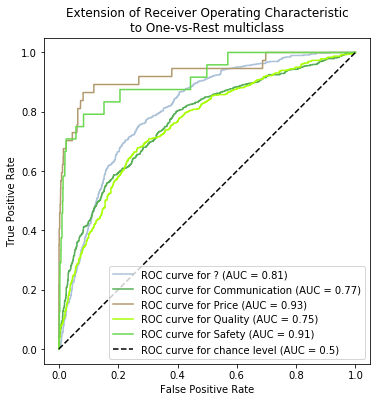

In [538]:
roc_curve(X_train_counts_c, y_train_c, X_test_counts_c, y_test_c, catg)

In [395]:
accuracy, precision, recall, f1 = get_metrics(y_test_c, y_predicted_c)
print("Метрики для категорий")
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

Метрики для категорий
accuracy = 0.555, precision = 0.566, recall = 0.555, f1 = 0.555


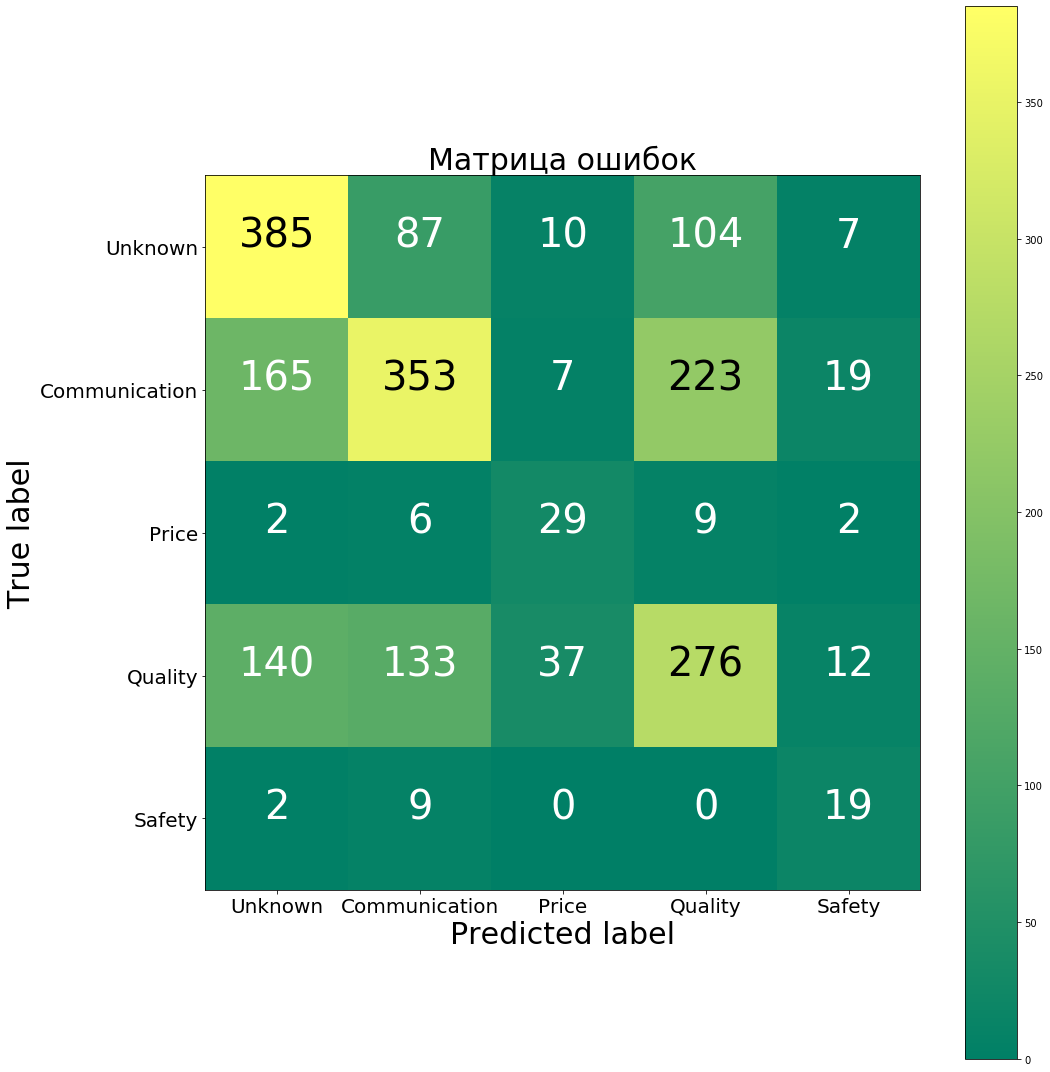

[[385  87  10 104   7]
 [165 353   7 223  19]
 [  2   6  29   9   2]
 [140 133  37 276  12]
 [  2   9   0   0  19]]


In [396]:
cm = confusion_matrix(y_test_c, y_predicted_counts_c)
fig = plt.figure(figsize=(15, 15))
plot = plot_confusion_matrix(cm, classes=['Unknown', 'Communication', 'Price', 'Quality', 'Safety'], normalize=False, title='Матрица ошибок')
plt.show()
print(cm)

## Итоговый файл с предсказаниями

In [578]:
ans_c.drop("?", axis=1, inplace=True)

In [583]:
ans_c.shape

(1937, 5)

In [581]:
ans_c.drop("sentence", axis=1, inplace=True)

In [582]:
# result = ans_s.set_index("Unnamed: 0").join(ans_c.set_index("Unnamed: 0"), how="left", on="sentence")
# result = ans_s.join(ans_c, how="left", on="Unnamed: 0")
result = ans_s.merge(ans_c, on="Unnamed: 0", how='outer')
print(result.shape)
result

(3654, 9)


,Unnamed: 0,sentence,+,?,−,Communication,Price,Quality,Safety
0,624,"Чувствуется заинтересованность, высокая клиент...",0.980565,0.017465,0.001970,NaN,NaN,NaN,NaN
1,17679,"По состоянию на 25.06.2020 деньги не вернули, ...",0.027685,0.117331,0.854984,0.478138,0.014350,0.436654,0.030477
2,8694,Ответ я получил просто фееричный - у нас нет т...,0.005867,0.066670,0.927463,NaN,NaN,NaN,NaN
3,3485,Так что не советую никому пользоваться услугам...,0.001327,0.007165,0.991508,NaN,NaN,NaN,NaN
4,1221,"Активно пользовался кредитной картой, которую ...",0.015888,0.973594,0.010518,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
3649,12335,NaN,NaN,NaN,NaN,0.157107,0.038632,0.503688,0.016293
3650,14883,NaN,NaN,NaN,NaN,0.121379,0.082826,0.359065,0.002498
3651,16746,NaN,NaN,NaN,NaN,0.071385,0.011591,0.859088,0.001090
3652,17837,NaN,NaN,NaN,NaN,0.130109,0.000985,0.599951,0.001655


In [554]:
ans_s.shape

(1937, 5)

In [601]:
#!g2.mig
check = pd.read_csv("/home/jupyter/mnt/s3/bac2/1sentencenewtest.csv", encoding="utf-8")
check.head()

,Unnamed: 0,0
0,0,15.03.2022 обратился на горячую линию для закр...
1,1,"Уже который год в ТКБ не решается ""глобальная ..."
2,2,Добрый день
3,3,"Добрый день Сегодня, зайдя в свой личный кабин..."
4,4,"Обслуживаюсь в Тинькофф пару лет, возникла жес..."


In [602]:
#!g2.mig
check.rename({"0": "sentence"}, axis=1, inplace=True)
check.head()

,Unnamed: 0,sentence
0,0,15.03.2022 обратился на горячую линию для закр...
1,1,"Уже который год в ТКБ не решается ""глобальная ..."
2,2,Добрый день
3,3,"Добрый день Сегодня, зайдя в свой личный кабин..."
4,4,"Обслуживаюсь в Тинькофф пару лет, возникла жес..."


In [603]:
#!g2.mig
clean_check = preproccesing_text(check, col="sentence")

In [604]:
#!g2.mig
clean_check.head()

,Unnamed: 0,sentence,tokens,norm,lemma,lemma_str
0,0,15.03.2022 обратился на горячую линию для закр...,"[15, 03, 2022, обратился, на, горячую, линию, ...","[состоянии, закрытии, 2022, счетов, счет, 2021...","[состояние, закрытие, 2022, счёт, счёт, 2021, ...",состояние закрытие 2022 счёт счёт 2021 справка...
1,1,"Уже который год в ТКБ не решается ""глобальная ...","[Уже, который, год, в, ТКБ, не, решается, глоб...","[банальной, проблема, глобальная, остатке, отп...","[банальный, проблема, глобальный, остаток, отп...",банальный проблема глобальный остаток отправка...
2,2,Добрый день,"[Добрый, день]","[добрый, день]","[добрый, день]",добрый день
3,3,"Добрый день Сегодня, зайдя в свой личный кабин...","[Добрый, день, Сегодня, зайдя, в, свой, личный...","[добрый, зайдя, моим, счетам, всем, вся, инфор...","[добрый, зайти, мой, счёт, весь, весь, информа...",добрый зайти мой счёт весь весь информация ден...
4,4,"Обслуживаюсь в Тинькофф пару лет, возникла жес...","[Обслуживаюсь, в, Тинькофф, пару, лет, возникл...","[акционерного, получении, инвестора, лет, тинь...","[акционерный, получение, инвестор, год, тинько...",акционерный получение инвестор год тинькофф во...


In [605]:
#!g2.mig
x = clean_check[["Unnamed: 0", "sentence", "lemma_str"]]
x_counts_s, count_vectorizer_s = bag_of_words(x["lemma_str"])

In [ ]:
#!g2.mig
words = set(x_counts_s) & set(X_train_counts_s.columns)

In [607]:
#!g2.mig
predicted_s = sentiment.predict(x_counts_s)
predicted_s

ValueError: X has 2587 features, but LogisticRegression is expecting 8613 features as input.